In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$\sigma^2 = \frac{2 k_B T \Delta t}{m \gamma}$$

In [2]:
#Parameters for the Brome Mosaic Virus
m = 7.6e-21      # kg
gamma = 3.4e10   # s^-1
dt = 10e-9       # s
T = 300          # K

kB = 1.380649e-23 # J/K

max_steps = 10000
x0 = 0           # m

sigma = np.sqrt(2*kB*T * dt / (m * gamma))  # m 

In [3]:
rng = np.random.default_rng()
steps = rng.normal(loc=0, scale=sigma, size=max_steps)

In [4]:
x_trajec=x0+np.cumsum(steps)

In [5]:
times = dt * np.arange(len(x_trajec))

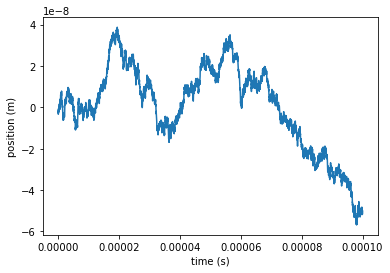

In [6]:
plt.plot(times, x_trajec)
plt.xlabel("time (s)")
plt.ylabel("position (m)");

In [7]:
N_steps=1000
steps=rng.normal(loc=0,scale=sigma,size=(N_steps,max_steps))
x_trajectories=x0+np.cumsum(steps,axis=1)

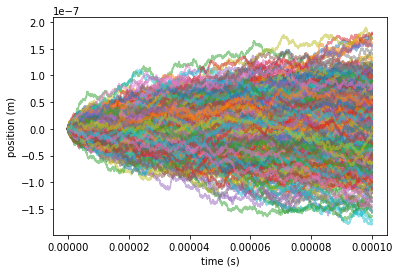

In [8]:
times = dt * np.arange(x_trajectories.shape[1])
plt.plot(times, x_trajectories.T, alpha=0.5);
plt.xlabel("time (s)")
plt.ylabel("position (m)");

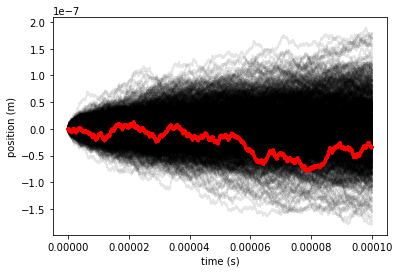

In [9]:
times = dt * np.arange(x_trajectories.shape[1])
plt.plot(times, x_trajectories.T, color="black", alpha=0.1);
plt.plot(times, x_trajectories[0], color="red", linewidth=3);
plt.xlabel("time (s)")
plt.ylabel("position (m)")
plt.savefig("diffusion_trajectories.png")

In [10]:
x_mean = x_trajectories.mean(axis=0)

In [11]:
np.mean(x_trajectories[:,0])

1.597226956036248e-11

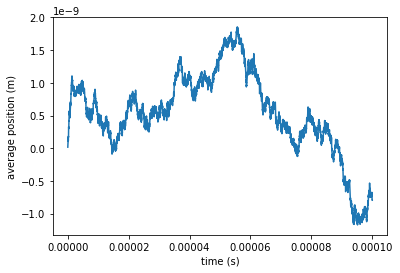

In [12]:
plt.plot(times, x_mean)
plt.xlabel("time (s)")
plt.ylabel("average position (m)");

In [13]:
MSD = np.mean((x_trajectories - x0)**2, axis=0)

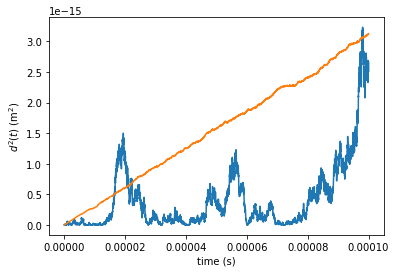

In [14]:
## Comparing for single trajectories vs groups
D2 = (x_trajec - x0)**2
plt.plot(times, D2)
plt.plot(times, MSD)
plt.xlabel("time (s)")
plt.ylabel(r"$d^2(t)$ (m$^2$)");

In [15]:
D = kB * T / (m * gamma)
print(D)

1.6029206656346748e-11


In [16]:
MSD_theory = 2 * D * times

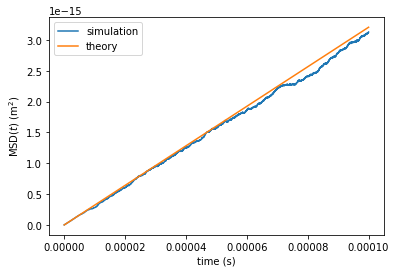

In [17]:
plt.plot(times, MSD, label="simulation")
plt.plot(times, MSD_theory, label="theory")
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)")
plt.legend();


In [18]:
np.mean((x_trajectories - x0)**2,axis=0)

array([3.07691976e-19, 6.79133020e-19, 9.23328820e-19, ...,
       3.12198889e-15, 3.12519481e-15, 3.12557382e-15])

In [19]:
def msd(t, D):
    return 2*D*t

In [20]:
# with pm.Model() as model:
#     D=pm.Uniform('D',lower=1.5029206656346748e-11,upper=1.7029206656346748e-11)
#     likelihood=pm.Normal('likelihood',mu=2*D*t,observed=MSD_theory)
#     trace = pm.sample(2000, init="adapt_diag", return_inferencedata=False)

# Using MCMC to determine the "D"
## We have theoritical value of D to be 1.6029206656346748e-11 which is used as a prior for MCMC: 
#### 1.5029206656346748e-11  >D or D>1.7029206656346748e-11;

In [35]:
def lnprob(D,t,MSD):
    from scipy import stats
    if np.isinf(D) or 1.5029206656346748e-11  >D or D>1.7029206656346748e-11:
        return -1e100
    g = stats.norm.pdf(MSD,2*D*t,3)
    ind_g = (np.isinf(g)==False) & (np.isnan(g)==False) & (g>0)
    logg = np.log(g[ind_g])
    ind_lg = logg>-1e100
    return np.sum(logg[ind_lg])

In [36]:
t=times

In [39]:
import emcee

pos =  1e-11 * np.random.randn(32, 1)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(MSD, t))
sampler.run_mcmc(pos, 2500, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:03<00:00, 780.16it/s]


Text(0, 0.5, 'D')

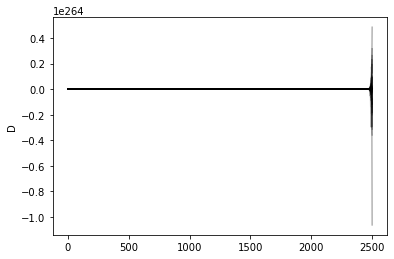

In [40]:

samples = sampler.get_chain()
labels = ["D"]
plt.plot(samples[:, :, 0], "k", alpha=0.3)
plt.ylabel(labels[0])

In [43]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(5120, 1)


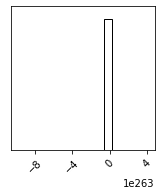

In [44]:
import corner

fig = corner.corner(
    flat_samples,
);

## We take the median of the samples as a best fit which is seem very close to theoritical value

In [45]:
D_fit=np.median(flat_samples)

In [46]:
MSD_fit=msd(D_fit,t)

In [47]:
D_fit ## Median of the samples

1.6060218589388618e-11

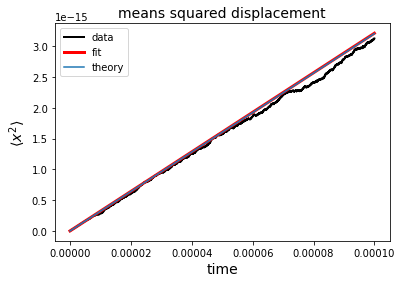

In [48]:
plt.plot(times,MSD , linestyle ='-',label='data', lw = 2, color = 'black')
plt.plot(times, MSD_fit, '-', label='fit', color = 'red',linewidth=3)
plt.plot(times, MSD_theory, label="theory")
plt.title('means squared displacement', fontsize = 14)
plt.ylabel(r'$\left<x^2\right>$', fontsize = 14)
plt.xlabel('time', fontsize = 14)
plt.legend()

# Visualizing the entire Result

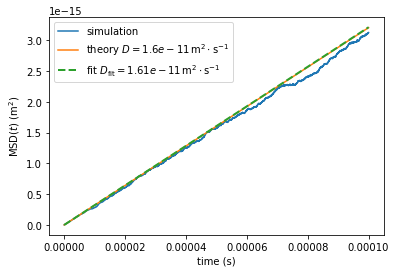

In [49]:
MSD_fit = msd(times, D_fit)
plt.plot(times, MSD, label="simulation")
plt.plot(times, MSD_theory, label=r"theory $D={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D))
plt.plot(times, MSD_fit, linestyle="--", linewidth=2,
         label=r"fit $D_\mathrm{{fit}}={0:.3g}\,\mathrm{{m}}^2\cdot\mathrm{{s}}^{{-1}}$".format(D_fit))
plt.xlabel("time (s)")
plt.ylabel(r"$\mathrm{MSD}(t)$ (m$^2$)")
plt.legend()